# Inference Demo with RETR

In [12]:
import numpy as np
from pathlib import Path
import torch
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from models import RETR
from data.det_seg_dataset import MMVRDetSeg
from utils.common import move_to_device

In [13]:
root = '/data/datasets/segment_4_3'  # path to dataset grouped MMVR folder
split = 'P2S1'

if split == 'P2S1':
    task = 'DETSEG'  # detection and segmentation model [DET/DETSEG]
    checkpoint = "../logs/pretrained_model/p2s1_retr_detseg.pth"  # path to pretrained model
elif split == 'P2S2':
    task = 'DETSEG'
    checkpoint = "../logs/pretrained_model/p2s2_retr_detseg.pth"
else:
    raise NotImplementedError
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setup Dataset and Dataloader

In [14]:
dataset_path = Path.joinpath(Path(root), split[:2])
test_dataset = MMVRDetSeg(
    dataset_path=dataset_path,
    split=split,
    type="test",
)

# Setup Model

In [15]:
model = RETR(task='SEG' if task == 'DETSEG' else 'DET').to(device)
params = torch.load(checkpoint,map_location=device)
model.load_state_dict(params)

<All keys matched successfully>

# Inference

In [16]:
batch = test_dataset.__getitem__(0)

batch = move_to_device(batch, device)
rf_hor = torch.stack([batch["hm_hori"].detach()])
rf_ver = torch.stack([batch["hm_vert"].detach()])
labels = [{
    "iboxes": batch["bbox_i"],
    "hboxes": batch["bbox_hori"],
    "vboxes": batch["bbox_vert"],
    "masks": batch["mask"],
    "n_sbj": batch["n_sbj"],
    "labels": batch["labels"],
    "file_id": batch["file_id"]}]

model.eval()
out = model(rf_hor, rf_ver)

## Visualization

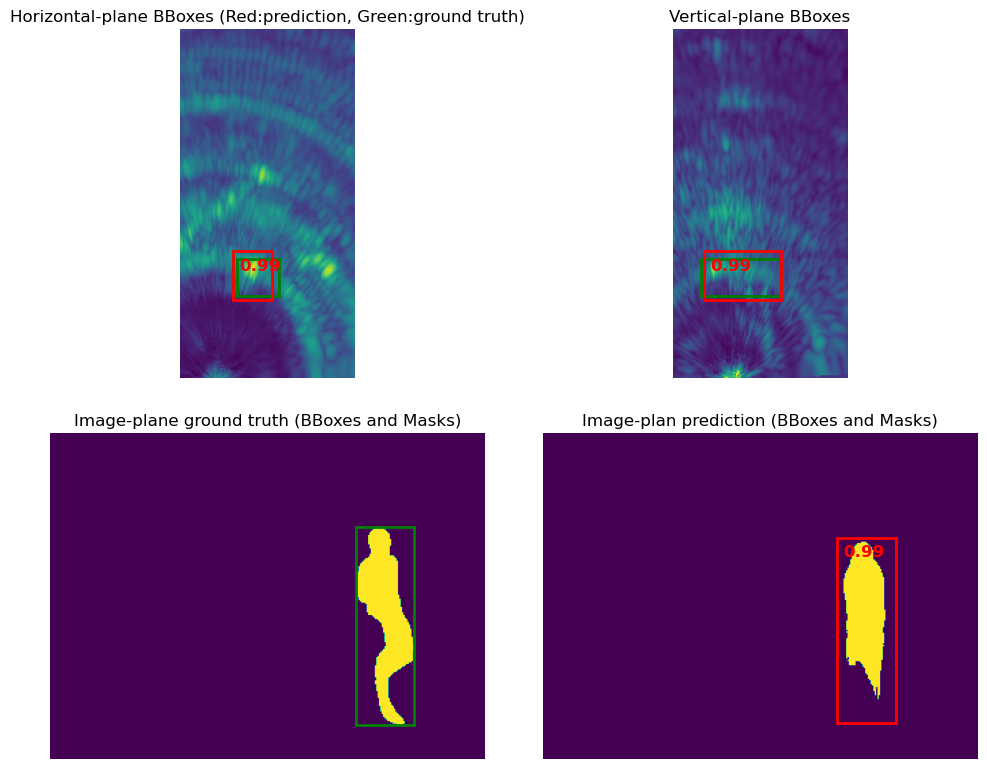

In [17]:
rf_hor, rf_ver = rf_hor[0].cpu().numpy(), rf_ver[0].cpu().numpy()
gtbbox_i, gtbbox_hori, gtbbox_vert, gtmask = \
    labels[0]["iboxes"].cpu().numpy(), \
    labels[0]["hboxes"].cpu().numpy(), \
    labels[0]["vboxes"].cpu().numpy(), \
    labels[0]["masks"].cpu().numpy()
prbbox_i, prbbox_hori, prbbox_vert = \
    out[0]["iboxes"].detach().cpu().numpy(), \
    out[0]["hboxes"].detach().cpu().numpy(), \
    out[0]["vboxes"].detach().cpu().numpy()
prmask = out[0]["masks_person"].detach().cpu().numpy() if task == 'DETSEG' else None
scores = out[0]["scores"].detach().cpu().numpy()

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
figure.tight_layout()
for ax, canvas, gt, pr, title, score in zip(
        [ax1, ax2, ax3, ax4],
        [rf_hor[-1], rf_ver[-1], np.sum(gtmask, axis=0), np.sum(prmask, axis=0)],
        [gtbbox_hori, gtbbox_vert, gtbbox_i, None],
        [prbbox_hori, prbbox_vert, None, prbbox_i],
        ["Horizontal-plane BBoxes (Red:prediction, Green:ground truth)", "Vertical-plane BBoxes", "Image-plane ground truth (BBoxes and Masks)", "Image-plan prediction (BBoxes and Masks)"],
        [scores, scores, scores, scores],
):
    ax.imshow(canvas)
    if gt is not None:
        for box in gt:
            x0, y0, x1, y1 = box
            rect = Rectangle((x0, y0), (x1 - x0), (y1 - y0), linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
    if pr is not None:
        for i, box in enumerate(pr):
            x0, y0, x1, y1 = box
            rect = Rectangle((x0, y0), (x1 - x0), (y1 - y0), linewidth=2, edgecolor='r', facecolor='none')
            ax.text(x0 + 5, y0 + 5, f"{score[i]:.2f}", color="red", verticalalignment='top', fontsize=12, fontweight='bold')
            ax.add_patch(rect)
    ax.set_title(title)
    ax.set_axis_off()
plt.show()
